In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import numpy as np
import seaborn as sns
import seaborn as sns

from src.ml_helpers.scorers import *
import jetson_configs as cfg

In [2]:
split_date = cfg.train_test_split
horizon = 1
admin_level = 'admin1'
fpath = f"{admin_level}_lag{horizon}"

# How do scores degrade with time?

In [3]:
master=pd.read_csv(f"ml/output_data/master_{fpath}.csv", 
                       parse_dates=['date'], 
                       index_col=['date', 'region'])

In [4]:
# TENTATIVE -- only use comparable predictions
#master.dropna(axis=0, inplace=True)

In [5]:
pd.crosstab(master.index.get_level_values("date"), master['dataset']).T

row_0,2011-01-01 00:00:00,2011-02-01 00:00:00,2011-03-01 00:00:00,2011-04-01 00:00:00,2011-05-01 00:00:00,2011-06-01 00:00:00,2011-07-01 00:00:00,2011-08-01 00:00:00,2011-09-01 00:00:00,2011-10-01 00:00:00,...,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00
dataset,,,,,,,,,,,,,,,,,,,,,
test,0,0,0,0,0,0,0,0,0,0,...,18,18,18,18,18,18,18,18,18,18
train,18,18,18,18,18,18,18,18,18,18,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Confirm equality of the columns
assert(  ((master.ml_true == master.true)          | (master.true.isna()|master.ml_true.isna())) .all())
assert(  ((master.dataset == master.ml_dataset)    | (master.dataset.isna()|master.ml_dataset.isna())  ) .all())

master.drop(columns=['dataset','ml_dataset',
                     #'ml_true', 'eur_true', 
                     #'internal_true', 'external_true', 'h2o_true'
                    ], inplace=True)

In [7]:
models = ['Randomforest', 'Adaboost', 'Ridge', 'Perceptron', #'SVM', 
          'Lasso', 'Decisiontree', 'Xgboost', 'lstm_12_100']

## MAE

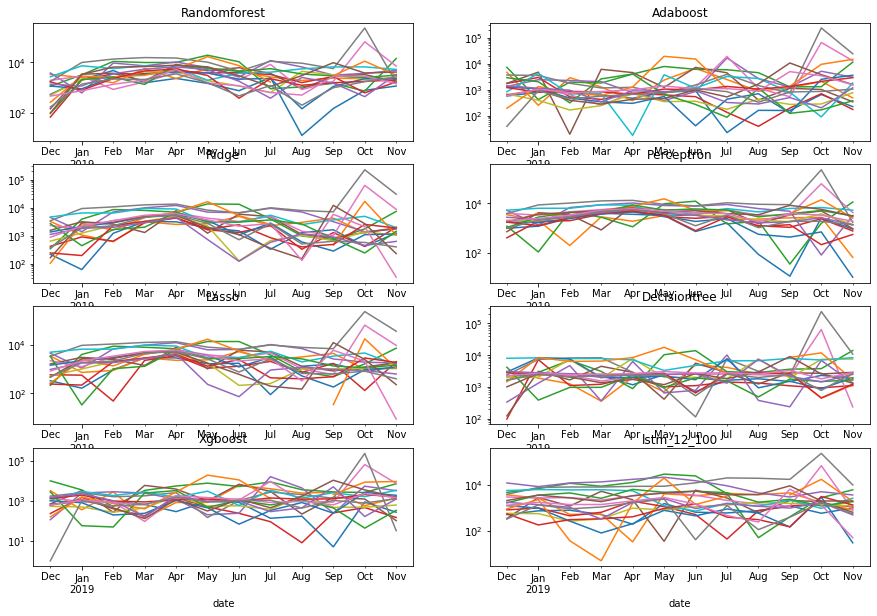

In [8]:
fig, ax = plt.subplots(4,2, figsize=[15,10])

for m in range(0,len(models)):
    i = m//2
    j = m%2
    
    scores = eval(master['true'], master[models[m]], 'mae', mean = False)
    scores.sort_index(inplace=True)
    scores.loc[split_date:].unstack(level='region').plot(legend=False, logy=True, ax = ax[i][j])
    ax[i][j].set_title(models[m])

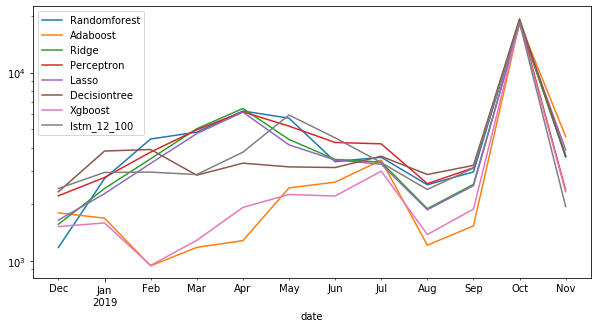

In [9]:
fig, ax = plt.subplots(1,1, figsize=[10,5])

for m in range(0,len(models)):
    i = m//2
    j = m%2
    
    scores = eval(master['true'], master[models[m]], 'mae', mean = False)
    scores.sort_index(inplace=True)
    
    scores.loc[split_date:].groupby(level='date').mean().plot(label=models[m], 
                                                            logy=True, legend=True, ax = ax)

## MSE

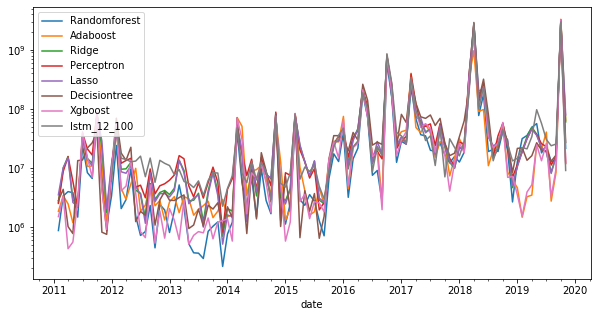

In [10]:
fig, ax = plt.subplots(1,1, figsize=[10,5])

for m in range(0,len(models)):
    i = m//2
    j = m%2
    
    scores = eval(master['true'], master[models[m]], 'mse', mean = False)
    scores.sort_index(inplace=True)
    
    scores.groupby(level='date').mean().plot(label=models[m], 
                                                            logy=True, legend=True, ax = ax)

# How do scores vary by region?

In [11]:
master_scored = master.copy()

for m in master_scored.columns:
    if m not in ['true', 'ml_true']:
        master_scored[m] = eval(master_scored['true'], master_scored[m], 'mse', mean = False)
        
master_scored.drop(['true', 'ml_true'], axis=1, inplace=True)

In [12]:
master_scored.sort_index(inplace=True)

In [13]:
plot_df_train = master_scored.loc[:split_date].groupby(level='region').mean()
plot_df_test = master_scored.loc[split_date:].groupby(level='region').mean()

In [14]:
np.sqrt(master_scored.loc[:split_date].dropna(how='any').mean().sort_values()).head()

lstm_12_100_1layer    1448.974935
lstm_12_50_1layer     1989.163151
lstm_6_100_1layer     2448.117557
lstm_6_50_1layer      2978.133092
lstm_12_50            4238.767617
dtype: float64

In [15]:
np.sqrt(master_scored.loc[split_date:].dropna(how='any').mean().sort_values()).head()

Decisiontree__tscv_yfill_yhist    16323.272979
hm_18                             17345.839282
Perceptron                        17355.404021
Perceptron_gbtscv                 17376.667269
Perceptron_tscv_yfill_noyhist     17378.234282
dtype: float64

In [16]:
np.sqrt(master_scored.loc[split_date:].dropna(how='any').mean().sort_values()).loc['lstm_12_100']

17575.052071346086

In [17]:
plot_df_train_rmse = np.sqrt(plot_df_train)
plot_df_test_rmse = np.sqrt(plot_df_test)

## Raw RMSE

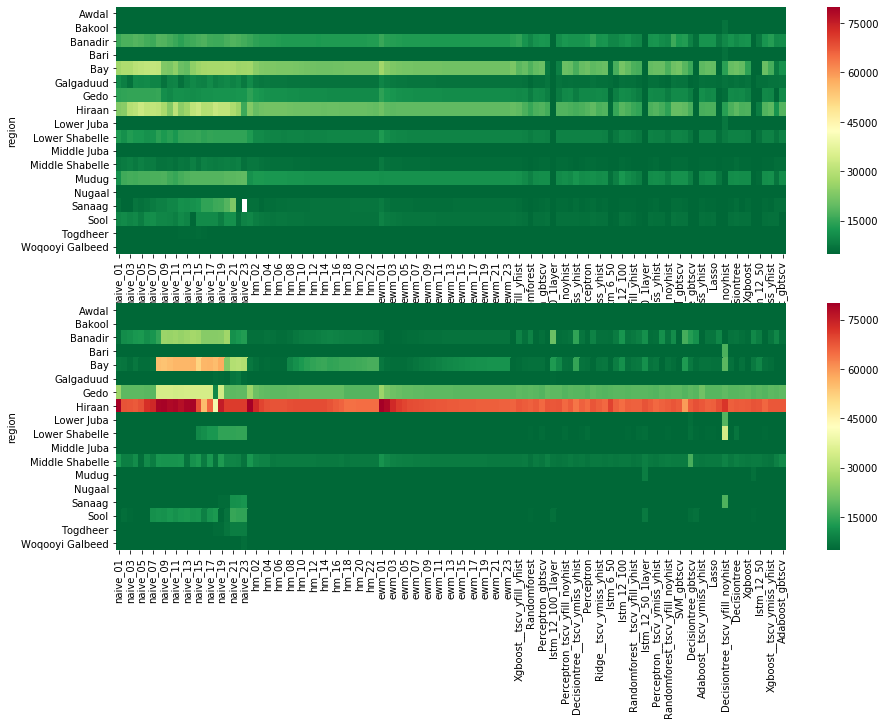

In [18]:
fig, ax = plt.subplots(2,1, figsize=[15,10])
sns.heatmap(plot_df_train_rmse,cmap='RdYlGn_r', ax=ax[0], vmin=5000, vmax=80000)
sns.heatmap(plot_df_test_rmse, cmap='RdYlGn_r', ax=ax[1], vmin=5000, vmax=80000)

## Ranked RMSE

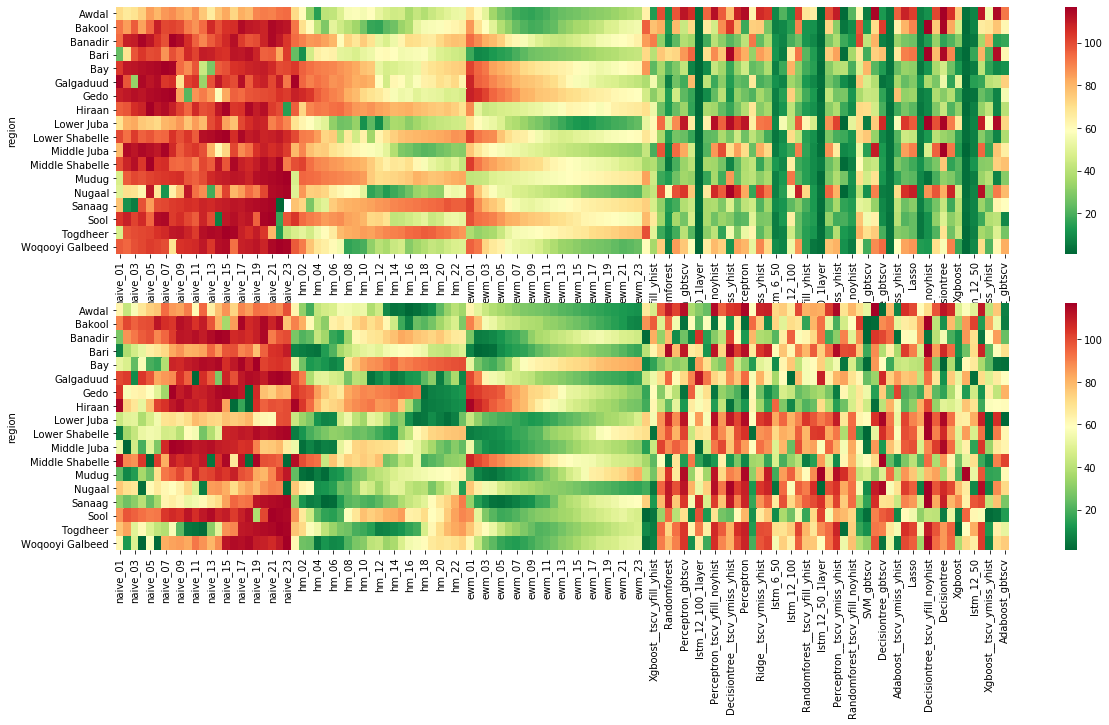

In [19]:
fig, ax = plt.subplots(2,1, figsize=[20,10])
sns.heatmap(plot_df_train.rank(axis=1), cmap='RdYlGn_r', ax=ax[0])
sns.heatmap(plot_df_test.rank(axis=1), cmap='RdYlGn_r', ax=ax[1])

## Raw RMSE -- train vs. test

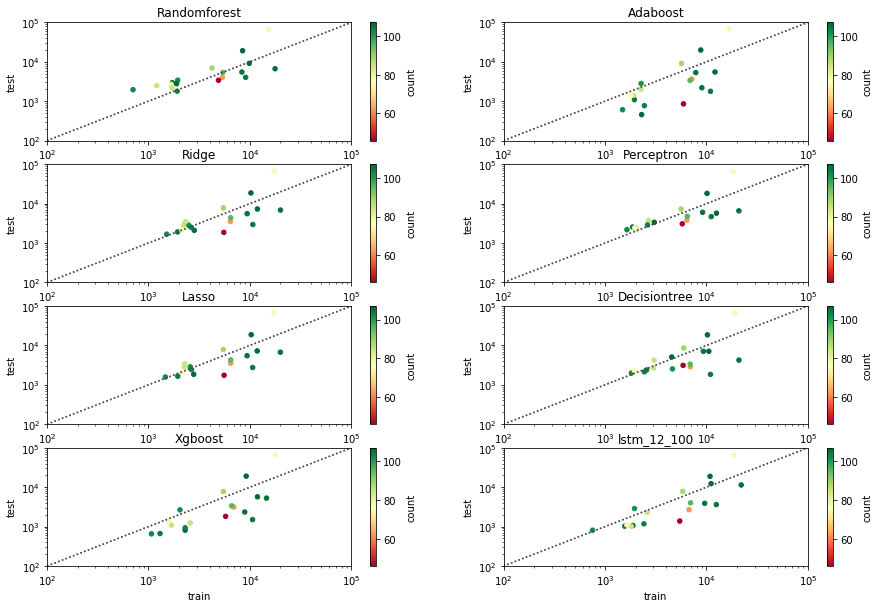

In [20]:
fig, ax = plt.subplots(4,2, figsize=[15,10])

for m in range(0,len(models)):
    i = m//2
    j = m%2
    
    
    plot_df = pd.concat([master.groupby(level='region').mean()[['true']], 
                         master.groupby(level='region').count()[['true']],
                         plot_df_train_rmse[models[m]],
                         plot_df_test_rmse[models[m]]],
                         axis=1)

    plot_df.columns=['true', 'count', 'train', 'test']

    plot_df.plot(x='train', y='test', kind='scatter', logx=True, logy=True, c='count', cmap='RdYlGn', ax=ax[i][j])

    lim=[100,100000]
    ax[i][j].set_xlim(lim)
    ax[i][j].set_ylim(lim)

    ax[i][j].plot(lim,lim, ls=":", c=".3")
    ax[i][j].plot(lim,lim, ls=":", c=".3")
    
    ax[i][j].set_title(models[m])

## Ranked RMSE -- train vs. test

In [21]:
plot_df_train_rmse_rank = plot_df_train_rmse.rank(axis=1)
plot_df_test_rmse_rank = plot_df_test_rmse.rank(axis=1)

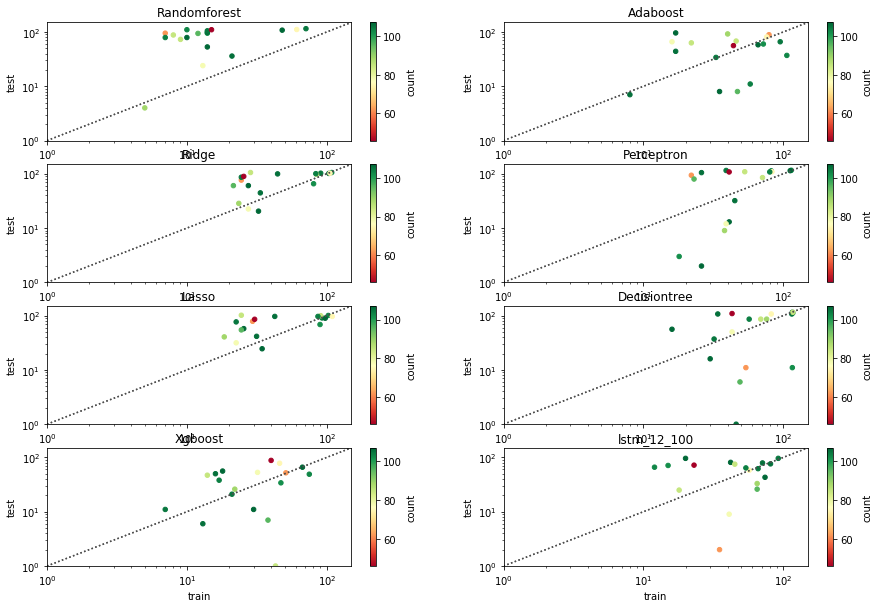

In [22]:
fig, ax = plt.subplots(4,2, figsize=[15,10])

for m in range(0,len(models)):
    i = m//2
    j = m%2
    
    
    plot_df = pd.concat([master.groupby(level='region').mean()[['true']], 
                         master.groupby(level='region').count()[['true']],
                         plot_df_train_rmse_rank[models[m]],
                         plot_df_test_rmse_rank[models[m]]],
                         axis=1)

    plot_df.columns=['true', 'count', 'train', 'test']

    plot_df.plot(x='train', y='test', kind='scatter', logx=True, logy=True, c='count', cmap='RdYlGn', ax=ax[i][j])

    lim=[1,150]
    ax[i][j].set_xlim(lim)
    ax[i][j].set_ylim(lim)

    ax[i][j].plot(lim,lim, ls=":", c=".3")
    ax[i][j].plot(lim,lim, ls=":", c=".3")
    
    ax[i][j].set_title(models[m])

# Evaluate generally

In [23]:
results = pd.concat([make_results("admin1_lag1", split_date),
                     make_results("admin1_lag3", split_date)], axis=1)

results = results.astype(float)
results.to_csv("ml/results/scored_models.csv")

## PCC

    plot_df = results.xs('pcc', level='metric').round(0).unstack(level='dataset').sort_values(('admin1_lag1', 'test'))
    plot_df.plot(kind='bar',
          color=['salmon', 'crimson', 'cornflowerblue', 'blue'], figsize=[15,5]) 

## RMSE

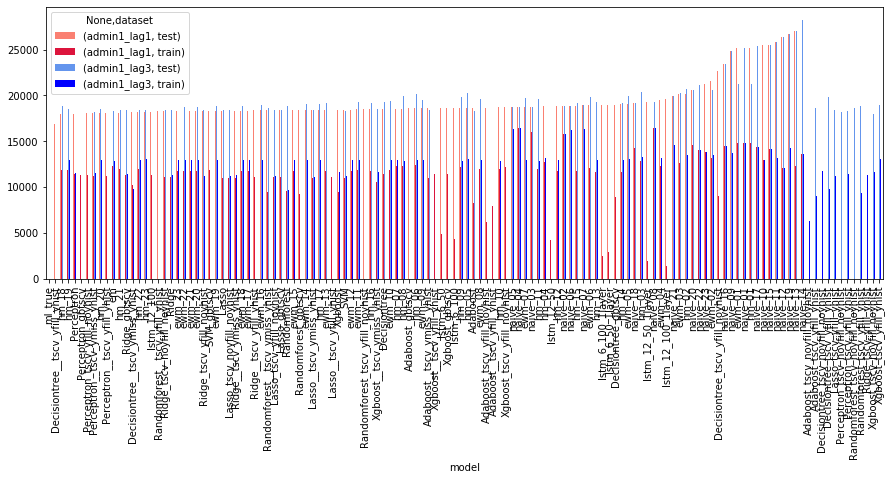

In [24]:
plot_df =  results.xs('rmse', level='metric').round(0).unstack(level='dataset').sort_values(('admin1_lag1', 'test'))
plot_df.plot(kind='bar',
             color=['salmon', 'crimson', 'cornflowerblue', 'blue'], figsize=[15,5]) #.xs("test", level="dataset").plot(kind='bar') #kind='bar') #.sort_values('admin1_lag3') #.xs("test", level="dataset").plot(kind='bar')

## MAE

    plot_df =  results.xs('mae', level='metric').round(0).unstack(level='dataset').sort_values(('admin1_lag1', 'test'))
    plot_df.plot(kind='bar',
                 color=['salmon', 'crimson', 'cornflowerblue', 'blue'], figsize=[15,5]) #.xs("test", level="dataset").plot(kind='bar') #kind='bar') #.sort_values('admin1_lag3') #.xs("test", level="dataset").plot(kind='bar')

## R^2

    plot_df =  results.xs('r2', level='metric').round(2).unstack(level='dataset').sort_values(('admin1_lag1', 'test'), ascending=False)
    plot_df.plot(kind='bar',
                 color=['salmon', 'crimson', 'cornflowerblue', 'blue'], figsize=[15,5]) #.xs("test", level="dataset").plot(kind='bar') #kind='bar') #.sort_values('admin1_lag3') #.xs("test", level="dataset").plot(kind='bar')

# Build Results table

## Print all results

In [25]:
results.xs('rmse', level='metric').round(0).unstack(level='dataset').sort_values(('admin1_lag1', 'train'))

admin1_lag1          admin1_lag3         
dataset                                  test    train        test    train
model                                                                      
ml_true                                   0.0      0.0         0.0      0.0
lstm_12_100_1layer                    19564.0   1449.0         NaN      NaN
lstm_12_50_1layer                     19258.0   1989.0         NaN      NaN
lstm_6_100_1layer                     18936.0   2448.0         NaN      NaN
lstm_6_50_1layer                      19001.0   2978.0         NaN      NaN
lstm_12_50                            18823.0   4239.0         NaN      NaN
lstm_6_100                            18650.0   4356.0         NaN      NaN
lstm_6_50                             18639.0   4905.0         NaN      NaN
Adaboost_tscv_yfill_noyhist           18684.0   6238.0         NaN      NaN
Adaboost__tscv_yfill_yhist            18686.0   7977.0         NaN      NaN
Adaboost                              18671.0   8265.0     18292.0   9147.0
Adaboost_gbtscv                       18586.0   8885.0         NaN      NaN
Decisiontree_gbtscv                   19011.0   8929.0         NaN      NaN
Decisiontree_tscv_yfill_noyhist       22648.0   8990.0         NaN      NaN
Randomforest_gbtscv                   18400.0   9263.0         NaN      NaN
Randomforest__tscv_ymiss_yhist        18376.0   9436.0     18636.0   9601.0
Randomforest_tscv_yfill_noyhist       18526.0   9470.0         NaN      NaN
Xgboost                               18454.0   9479.0     18027.0  11700.0
Randomforest                          18388.0   9624.0     18851.0   9687.0
Randomforest__tscv_yfill_yhist        18266.0   9812.0         NaN      NaN
Decisiontree__tscv_ymiss_yhist        18152.0  10195.0     19753.0   9756.0
Xgboost__tscv_ymiss_yhist             18540.0  10602.0     18489.0  11628.0
Adaboost__tscv_ymiss_yhist            18632.0  10995.0     18424.0   8886.0
Lasso__tscv_ymiss_yhist               18419.0  11019.0     18376.0  11119.0
Ridge__tscv_ymiss_yhist               18332.0  11035.0     18389.0  11341.0
Lasso_tscv_noyfill_noyhist            18328.0  11043.0     18391.0  11182.0
Lasso                                 18328.0  11043.0     18391.0  11182.0
SVM                                   18460.0  11043.0     18267.0  11171.0
Ridge_tscv_noyfill_noyhist            18271.0  11065.0     18376.0  11366.0
Ridge                                 18271.0  11065.0     18376.0  11366.0
...                                       ...      ...         ...      ...
naive_22                              21093.0  14027.0     21093.0  14027.0
naive_15                              25541.0  14161.0     25541.0  14161.0
naive_18                              19135.0  14238.0     19135.0  14238.0
naive_19                              26714.0  14282.0     26714.0  14282.0
naive_17                              25349.0  14381.0     25349.0  14381.0
naive_16                              23455.0  14536.0     23455.0  14536.0
naive_21                              19968.0  14554.0     19968.0  14554.0
naive_20                              20607.0  14583.0     20607.0  14583.0
hm_01                                 25231.0  14763.0     21228.0  13869.0
naive_01                              25231.0  14763.0     25231.0  14763.0
ewm_01                                25231.0  14763.0     21228.0  13869.0
naive_02                              18838.0  15798.0     18838.0  15798.0
naive_03                              18772.0  16016.0     18772.0  16016.0
naive_06                              18839.0  16227.0     18839.0  16227.0
naive_07                              18906.0  16304.0     18906.0  16304.0
naive_05                              18750.0  16394.0     18750.0  16394.0
naive_08                              19270.0  16405.0     19270.0  16405.0
naive_04                              18769.0  16424.0     18769.0  16424.0
Adaboost_tscv_noyfill_noyhist             NaN      NaN     18652.0   6307.0
Adaboo

## Get top performing baseline models

In [26]:
plot_df = results.xs('rmse', level='metric').round(0).unstack(level='dataset') #.sort_index()

In [27]:
plot_df['model_class'] = plot_df.index.get_level_values(0)
plot_df['model_class'] = plot_df['model_class'].apply(lambda x: x.split("_")[0])

In [28]:
[i for i in plot_df.sort_values(('admin1_lag1', 'train')).index.get_level_values(0).tolist() if 'ewm' in i][:3]

['ewm_18', 'ewm_17', 'ewm_19']

In [29]:
[i for i in plot_df.sort_values(('admin1_lag3', 'train')).index.get_level_values(0).tolist() if 'ewm' in i][:3]

['ewm_15', 'ewm_17', 'ewm_16']

In [30]:
[i for i in plot_df.sort_values(('admin1_lag1', 'train')).index.get_level_values(0).tolist() if 'hm' in i][:3]

['hm_13', 'hm_14', 'hm_15']

In [31]:
[i for i in plot_df.sort_values(('admin1_lag3', 'train')).index.get_level_values(0).tolist() if 'hm' in i][:3]

['hm_09', 'hm_10', 'hm_08']

In [32]:
[i for i in plot_df.sort_values(('admin1_lag1', 'train')).index.get_level_values(0).tolist() if 'naive' in i][:3]

['naive_12', 'naive_13', 'naive_10']

In [33]:
[i for i in plot_df.sort_values(('admin1_lag3', 'train')).index.get_level_values(0).tolist() if 'naive' in i][:3]

['naive_12', 'naive_13', 'naive_10']

In [34]:
cols = ['Decisiontree', 'Randomforest', 'Lasso', 'Ridge', 'SVM', 'Adaboost', 'Xgboost', 'Perceptron', 'lstm_6_50',
            'em', 'ewm_18', 'ewm_15', 'hm_13', 'hm_09', 'naive_12']

In [35]:
rename_cols = {'Decisiontree': 'Decision Tree', 
               'Randomforest':'Random Forest', 
               'Adaboost':'AdaBoost', 
               'Xgboost':'XGBoost', 
               'lstm_6_50': "LSTM",
               "em": "Expand. Mean",
               'ewm_18': "Exp. Wt. Mean (18)", 
               'ewm_15': "Exp. Wt. Mean (15)", 
               'hm_13': 'Hist. Mean (13)', 
               'hm_09': 'Hist. Mean (9)', 
               'naive_12': 'Lag'}

## Table of top models 

In [36]:
plot_df = plot_df.T.rename(columns=rename_cols).T

cols = [rename_cols[i] if i in rename_cols.keys()  else i for i in cols   ]

plot_df = plot_df.loc[cols].sort_values(('admin1_lag1', 'test'))

plot_df = plot_df.fillna("-")

plot_df

admin1_lag1          admin1_lag3          model_class
dataset                   test    train        test  train              
model                                                                   
Perceptron             18021.0  11423.0       18229  11508    Perceptron
Expand. Mean           18083.0  12338.0       18319  12871            em
Ridge                  18271.0  11065.0       18376  11366         Ridge
Lasso                  18328.0  11043.0       18391  11182         Lasso
Exp. Wt. Mean (18)     18341.0  11776.0       18860  12921           ewm
Random Forest          18388.0   9624.0       18851   9687  Randomforest
Exp. Wt. Mean (15)     18389.0  11783.0       19015  12920           ewm
XGBoost                18454.0   9479.0       18027  11700       Xgboost
SVM                    18460.0  11043.0       18267  11171           SVM
Decision Tree          18544.0  11432.0       19321   9662  Decisiontree
LSTM                   18639.0   4905.0           -      -          lstm
Hist. Mean (9)         18654.0  12167.0       19826  12876            hm
AdaBoost               18671.0   8265.0       18292   9147      Adaboost
Hist. Mean (13)        18911.0  11665.0       19299  12929            hm
Lag                    26349.0  12083.0       26349  12083         naive

In [37]:
for i, row in plot_df.iterrows():
    print (i, "&", " & ".join([str(i).replace(".0", "") for i in row.values.tolist()[:-1] if ~pd.isna(i)] ), "\\\\")

Perceptron & 18021 & 11423 & 18229 & 11508 \\
Expand. Mean & 18083 & 12338 & 18319 & 12871 \\
Ridge & 18271 & 11065 & 18376 & 11366 \\
Lasso & 18328 & 11043 & 18391 & 11182 \\
Exp. Wt. Mean (18) & 18341 & 11776 & 18860 & 12921 \\
Random Forest & 18388 & 9624 & 18851 & 9687 \\
Exp. Wt. Mean (15) & 18389 & 11783 & 19015 & 12920 \\
XGBoost & 18454 & 9479 & 18027 & 11700 \\
SVM & 18460 & 11043 & 18267 & 11171 \\
Decision Tree & 18544 & 11432 & 19321 & 9662 \\
LSTM & 18639 & 4905 & - & - \\
Hist. Mean (9) & 18654 & 12167 & 19826 & 12876 \\
AdaBoost & 18671 & 8265 & 18292 & 9147 \\
Hist. Mean (13) & 18911 & 11665 & 19299 & 12929 \\
Lag & 26349 & 12083 & 26349 & 12083 \\


In [38]:
master.true.mean()

3554.6181055155876

In [39]:
master.true.std()

11277.81326438041

In [40]:
master.true.max()

235069.0

## Plot ranked errors

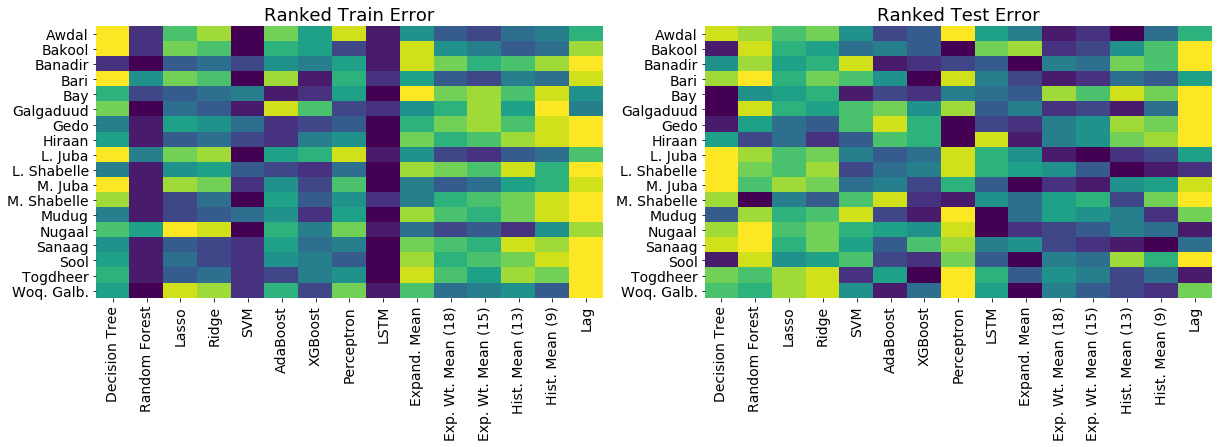

In [41]:
plot_df_train.rename(columns=rename_cols, inplace=True)
plot_df_test.rename(columns=rename_cols, inplace=True)

fig, ax = plt.subplots(1,2, figsize=[20,5])
sns.heatmap(plot_df_train[cols].rank(axis=1), cmap='viridis', ax=ax[0], cbar=None)
sns.heatmap(plot_df_test[cols].rank(axis=1), cmap='viridis', ax=ax[1], cbar=None)

ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[0].set_title("Ranked Train Error", fontsize=18)
ax[1].set_title("Ranked Test Error", fontsize=18)

ax[0].set_yticklabels([i.replace("Middle", "M.").replace("Lower", "L.").replace("Woqooyi", "Woq.").replace("Galbeed", "Galb.")  
                    for i in plot_df_train.index], fontsize=14)


ax[1].set_yticklabels([i.replace("Middle", "M.").replace("Lower", "L.").replace("Woqooyi", "Woq.").replace("Galbeed", "Galb.")  
                    for i in plot_df_test.index], fontsize=14)

for tick in ax[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
    
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
    



plt.savefig("figures/ranked_error.png", dpi=100, bbox_inches="tight")